# Probabilistic Model of breast cancer patient survival

The Haberman Dataset describes the five year or greater survival of breast cancer patient patients in the 1950s and 1960s and mostly contains patients that survive. This standard machine learning dataset can be used as the basis of developing a probabilistic model that predicts the probability of survival of a patient given a few details of their case.


Given the skewed distribution in cases in the dataset, careful attention must be paid to both the choice of predictive models to ensure that calibrated probabilities are predicted, and to the choice of model evaluation to ensure that the models are selected based on the skill of their predicted probabilities rather than crisp survival vs. non-survival class labels

# Haberman Breast Cancer Survival Dataset

The dataset describes breast cancer patient data and the outcome is patient survival. Specifically whether the patient survived for five years or longer, or whether the patient did not survive.

There are 306 examples in the dataset, and there are 3 input variables; they are:

- The age of the patient at the time of the operation.
- The two-digit year of the operation.
- The number of “positive axillary nodes” detected, a measure of a cancer has spread.

**Given patient breast cancer surgery details, what is the probability of survival of the patient to five years or more?**

This will provide the basis for exploring probabilistic algorithms that can predict a probability instead of a class label and metrics for evaluating models that predict probabilities instead of class labels.

# Explore the dataset

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


In [41]:
# define the dataset location
filename = 'haberman.csv'
# define the dataset column names
columns = ['age', 'year', 'nodes', 'class']
# load the csv file as a data frame
dataframe = pd.read_csv(filename, header=None, names=columns)

In [42]:
# summarize each column
report = dataframe.describe()
print(report)

              age        year       nodes       class
count  306.000000  306.000000  306.000000  306.000000
mean    52.457516   62.852941    4.026144    1.264706
std     10.803452    3.249405    7.189654    0.441899
min     30.000000   58.000000    0.000000    1.000000
25%     44.000000   60.000000    0.000000    1.000000
50%     52.000000   63.000000    1.000000    1.000000
75%     60.750000   65.750000    4.000000    2.000000
max     83.000000   69.000000   52.000000    2.000000


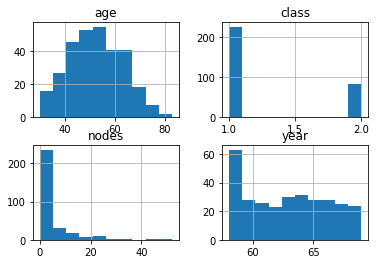

In [43]:
# create a histogram plot of each variable
dataframe.hist()
plt.show()

In [44]:
# summarize the class distribution
target = dataframe['class'].values
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=1, Count=225, Percentage=73.529%
Class=2, Count=81, Percentage=26.471%


# Model Test and Basseline Result
We will evaluate candidate models using repeated stratified k-fold cross-validation.

The k-fold cross-validation procedure provides a good general estimate of model performance that is not too optimistically biased, at least compared to a single train-test split. We will use k=10, meaning each fold will contain 306/10 or about 30 examples.

Stratified means that each fold will contain the same mixture of examples by class, that is about 74 percent to 26 percent survival and non-survival.

Repeated means that the evaluation process will be performed multiple times to help avoid fluke results and better capture the variance of the chosen model. We will use three repeats.

In [45]:
# baseline model and test harness for the haberman dataset
from collections import Counter
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

In [46]:
# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	data = read_csv(full_path, header=None)
	# retrieve numpy array
	data = data.values
	# split into input and output elements
	X, y = data[:, :-1], data[:, -1]
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X, y

In [47]:
# calculate brier skill score (BSS)
def brier_skill_score(y_true, y_prob):
	# calculate reference brier score
	ref_probs = [0.26471 for _ in range(len(y_true))]
	bs_ref = brier_score_loss(y_true, ref_probs)
	# calculate model brier score
	bs_model = brier_score_loss(y_true, y_prob)
	# calculate skill score
	return 1.0 - (bs_model / bs_ref)

In [48]:
# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation the metric
	metric = make_scorer(brier_skill_score, needs_proba=True)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

In [49]:
# define the location of the dataset
full_path = 'haberman.csv'
# load the dataset
X, y = load_dataset(full_path)
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='prior')
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean BSS: %.3f (%.3f)' % (mean(scores), std(scores)))

(306, 3) (306,) Counter({0: 225, 1: 81})
Mean BSS: -0.000 (0.000)


# Evaluate Probabilistic Models

## Probabilistic Algorithm Evaluation

- Logistic Regression (LogisticRegression)
- Linear Discriminant Analysis (LinearDiscriminantAnalysis)
- Quadratic Discriminant Analysis (QuadraticDiscriminantAnalysis)
- Gaussian Naive Bayes (GaussianNB)
- Multinomial Naive Bayes (MultinomialNB)
- Gaussian Process Classifier (GaussianProcessClassifier)

In [50]:
# compare probabilistic model on the haberman dataset
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier

In [51]:
# define models
models = [LogisticRegression(solver='lbfgs'), LinearDiscriminantAnalysis(),
	QuadraticDiscriminantAnalysis(), GaussianNB(), MultinomialNB(),
	GaussianProcessClassifier()]
names, values = list(), list()

In [52]:
# evaluate each model
for model in models:
	# get a name for the model
	name = type(model).__name__[:7]
	# evaluate the model and store results
	scores = evaluate_model(X, y, model)
	# summarize and store
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
	names.append(name)
	values.append(scores)

>Logisti 0.064 (0.123)
>LinearD 0.067 (0.136)
>Quadrat 0.027 (0.212)
>Gaussia 0.011 (0.209)
>Multino -0.213 (0.380)
>Gaussia -0.141 (0.047)


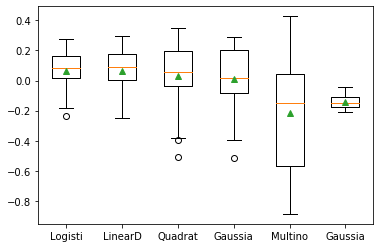

In [53]:
# plot the results
plt.boxplot(values, labels=names, showmeans=True)
plt.show()

# Model Evaluation With Scaled Inputs

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [55]:
# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	data = read_csv(full_path, header=None)
	# retrieve numpy array
	data = data.values
	# split into input and output elements
	X, y = data[:, :-1], data[:, -1]
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X, y
 

In [56]:
# calculate brier skill score (BSS)
def brier_skill_score(y_true, y_prob):
	# calculate reference brier score
	ref_probs = [0.26471 for _ in range(len(y_true))]
	bs_ref = brier_score_loss(y_true, ref_probs)
	# calculate model brier score
	bs_model = brier_score_loss(y_true, y_prob)
	# calculate skill score
	return 1.0 - (bs_model / bs_ref)

In [57]:
# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation the metric
	metric = make_scorer(brier_skill_score, needs_proba=True)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

In [58]:
# define the location of the dataset
full_path = 'haberman.csv'
# load the dataset
X, y = load_dataset(full_path)

In [59]:
# define models
models = [LogisticRegression(solver='lbfgs'), LinearDiscriminantAnalysis(),
	QuadraticDiscriminantAnalysis(), GaussianNB(), GaussianProcessClassifier()]
names, values = list(), list()
# evaluate each model
for model in models:
	# get a name for the model
	name = type(model).__name__[:7]
	# create a pipeline
	pip = Pipeline(steps=[('t', StandardScaler()),('m',model)])
	# evaluate the model and store results
	scores = evaluate_model(X, y, pip)
	# summarize and store
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
	names.append(name)
	values.append(scores)

>Logisti 0.065 (0.121)
>LinearD 0.067 (0.136)
>Quadrat 0.027 (0.212)
>Gaussia 0.011 (0.209)
>Gaussia 0.092 (0.106)


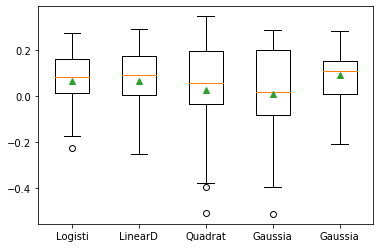

In [60]:
# plot the results
pyplot.boxplot(values, labels=names, showmeans=True)
pyplot.show()

# Model Evaluation With Power Transform

In [61]:
# compare probabilistic models with power transforms on the haberman dataset
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

In [62]:
# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	data = read_csv(full_path, header=None)
	# retrieve numpy array
	data = data.values
	# split into input and output elements
	X, y = data[:, :-1], data[:, -1]
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X, y

In [63]:
# calculate brier skill score (BSS)
def brier_skill_score(y_true, y_prob):
	# calculate reference brier score
	ref_probs = [0.26471 for _ in range(len(y_true))]
	bs_ref = brier_score_loss(y_true, ref_probs)
	# calculate model brier score
	bs_model = brier_score_loss(y_true, y_prob)
	# calculate skill score
	return 1.0 - (bs_model / bs_ref)

In [64]:
# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation the metric
	metric = make_scorer(brier_skill_score, needs_proba=True)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

In [65]:
# define the location of the dataset
full_path = 'haberman.csv'
# load the dataset
X, y = load_dataset(full_path)
# define models
models = [LogisticRegression(solver='lbfgs'), LinearDiscriminantAnalysis(), GaussianProcessClassifier()]
names, values = list(), list()
# evaluate each model
for model in models:
	# get a name for the model
	name = type(model).__name__[:7]
	# create a pipeline
	pip = Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()),('m',model)])
	# evaluate the model and store results
	scores = evaluate_model(X, y, pip)
	# summarize and store
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
	names.append(name)
	values.append(scores)

>Logisti 0.111 (0.123)
>LinearD 0.106 (0.147)
>Gaussia 0.103 (0.096)


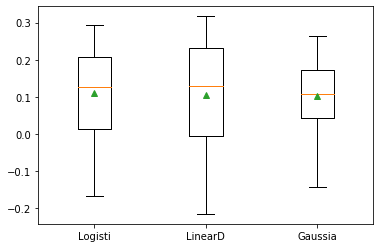

In [66]:
# plot the results
pyplot.boxplot(values, labels=names, showmeans=True)
pyplot.show()

# Make Prediction on New Data

In [67]:
# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	data = read_csv(full_path, header=None)
	# retrieve numpy array
	data = data.values
	# split into input and output elements
	X, y = data[:, :-1], data[:, -1]
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X, y

In [68]:
# define the location of the dataset
full_path = 'haberman.csv'
# load the dataset
X, y = load_dataset(full_path)
# fit the model
model = Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()),('m',LogisticRegression(solver='lbfgs'))])
model.fit(X, y)
# some survival cases
print('Survival Cases:')
data = [[31,59,2], [31,65,4], [34,60,1]]
for row in data:
	# make prediction
	yhat = model.predict_proba([row])
	# get percentage of survival
	p_survive = yhat[0, 0] * 100
	# summarize
	print('>data=%s, Survival=%.3f%%' % (row, p_survive))
# some non-survival cases
print('Non-Survival Cases:')
data = [[44,64,6], [34,66,9], [38,69,21]]
for row in data:
	# make prediction
	yhat = model.predict_proba([row])
	# get percentage of survival
	p_survive = yhat[0, 0] * 100
	# summarize
	print('data=%s, Survival=%.3f%%' % (row, p_survive))

Survival Cases:
>data=[31, 59, 2], Survival=83.597%
>data=[31, 65, 4], Survival=77.264%
>data=[34, 60, 1], Survival=86.776%
Non-Survival Cases:
data=[44, 64, 6], Survival=63.092%
data=[34, 66, 9], Survival=63.452%
data=[38, 69, 21], Survival=53.389%
